In [1]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [2]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 

    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
   
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
      
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


## DATA ARRANGEMENT

In [9]:
# !pip install moviepy

In [10]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [14]:
DATA_PATH

'data2'

In [15]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [16]:
np.array(sequences).shape

(450, 30, 1662)

In [17]:
np.array(labels).shape

(450,)

In [18]:
X = np.array(sequences)

In [19]:
X.shape

(450, 30, 1662)

In [20]:
y = to_categorical(labels).astype(int)

In [21]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

In [27]:
y_test.shape

(36, 6)

In [28]:
emotion_labels_train, emotion_labels_test=y_train, y_test

## Build Network

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense,Input
from tensorflow.keras.callbacks import TensorBoard

In [38]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [39]:
import tensorflow as tf

In [40]:
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        super(Attention, self).build(input_shape)

    def call(self, q, k, v):
        # Calculate attention scores using scalar dot product
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        return output, attention_scores

In [41]:
input_layer = Input(shape=(30, 1662))

# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', return_state=True)
output, state_h, state_c = lstm_layer(input_layer)

# Attention layer
attention_layer = Attention()  # You might need to adjust this based on your Attention layer implementation.
output, attention_scores = attention_layer(output, output, output)

# Continue with the rest of your model architecture using 'output'
x = LSTM(128, return_sequences=True, activation='relu')(output)
x = LSTM(64, return_sequences=False, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(actions.shape[0], activation='softmax')(x)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 1662)]           0         []                            
                                                                                                  
 lstm_3 (LSTM)               [(None, 30, 64),             442112    ['input_2[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 attention_1 (Attention)     ((None, 30, 64),             0         ['lstm_3[0][0]',              
                              (None, 30, 30))                        'lstm_3[0][0]',        

In [44]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
13/13 [==============================] - 9s 135ms/step - loss: 9.8306 - accuracy: 0.1787
Epoch 2/50
13/13 [==============================] - 2s 135ms/step - loss: 26.6480 - accuracy: 0.1932
Epoch 3/50
13/13 [==============================] - 2s 155ms/step - loss: 23.7447 - accuracy: 0.1667
Epoch 4/50
13/13 [==============================] - 2s 136ms/step - loss: 15.9107 - accuracy: 0.1860
Epoch 5/50
13/13 [==============================] - 2s 152ms/step - loss: 19.3187 - accuracy: 0.1908
Epoch 6/50
13/13 [==============================] - 2s 128ms/step - loss: 19.7987 - accuracy: 0.1232
Epoch 7/50
13/13 [==============================] - 2s 130ms/step - loss: 9.7848 - accuracy: 0.1401
Epoch 8/50
13/13 [==============================] - 8s 668ms/step - loss: 4.2557 - accuracy: 0.2198
Epoch 9/50
13/13 [==============================] - 7s 517ms/step - loss: 2.8344 - accuracy: 0.2174
Epoch 10/50
13/13 [==============================] - 2s 131ms/step - loss: 3.0528 - accuracy: 0

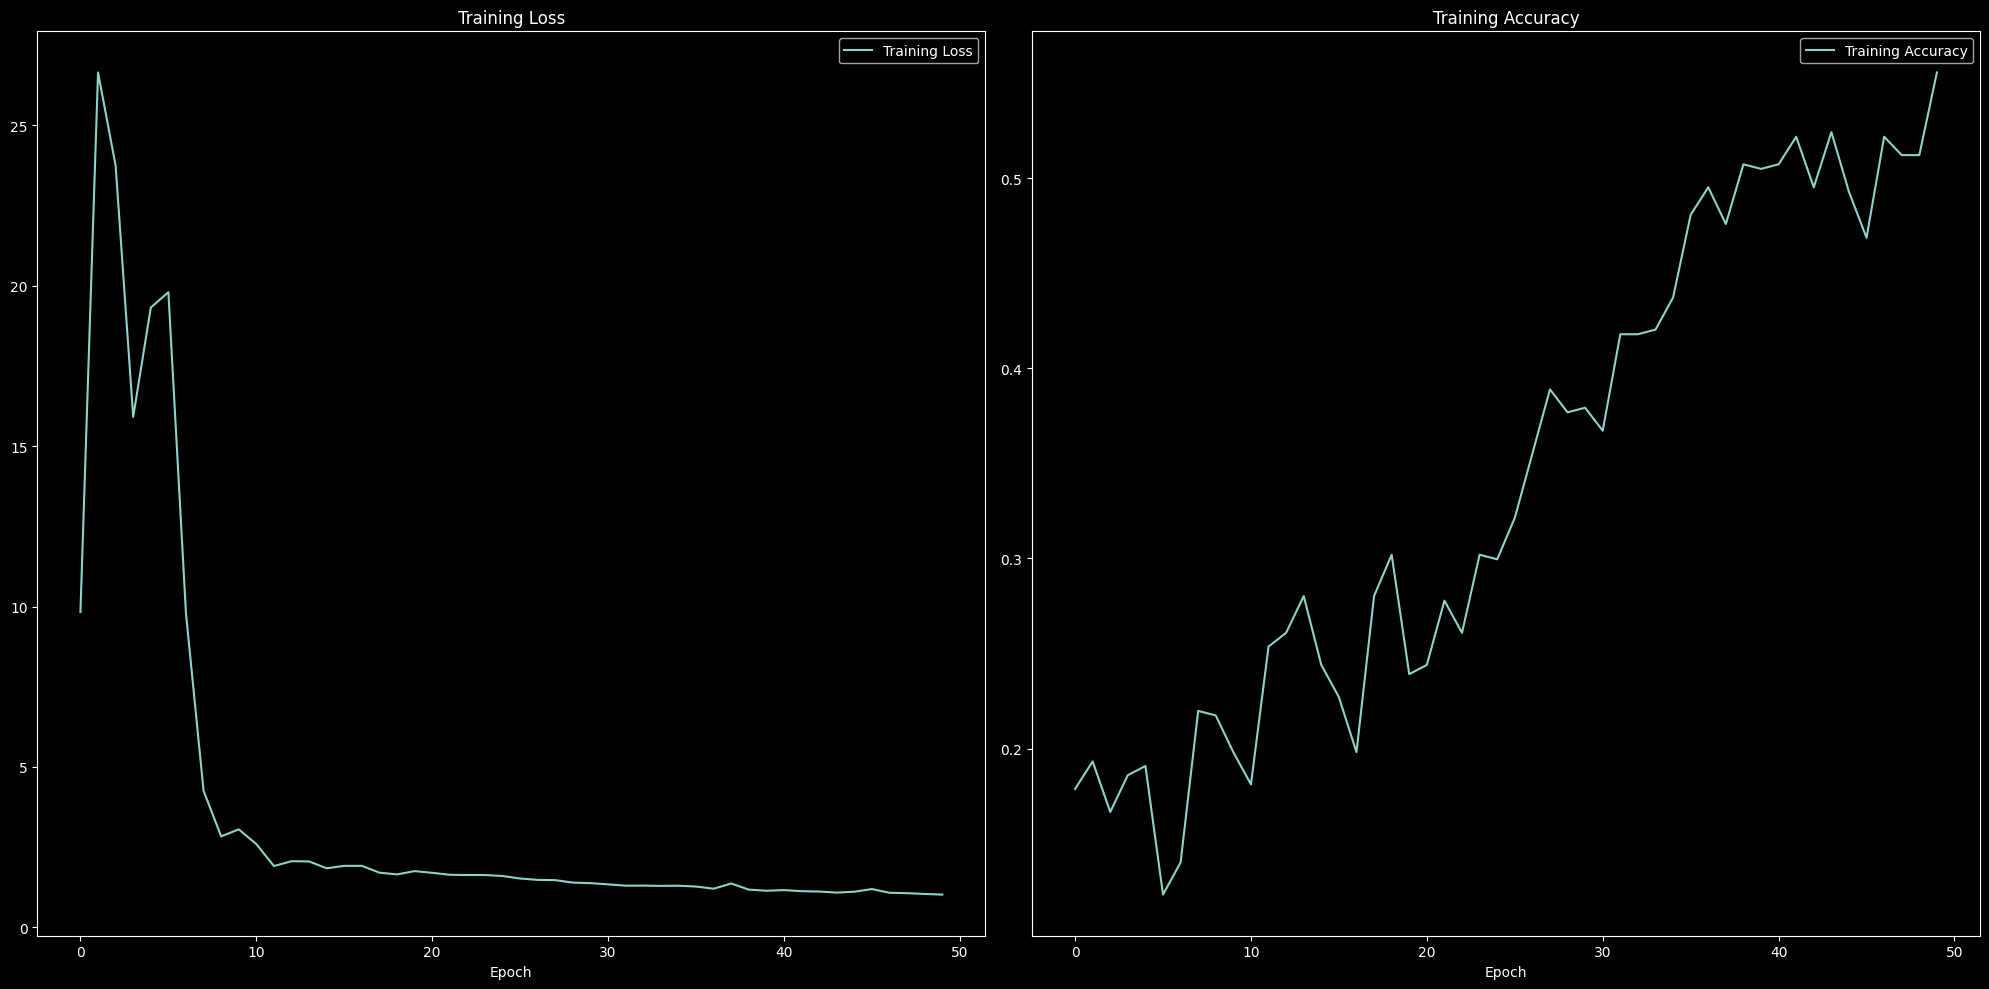

In [45]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
attention_scores

<KerasTensor: shape=(None, 30, 30) dtype=float32 (created by layer 'attention_1')>

In [49]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
_, test1, _, test1_label = train_test_split(X, y, test_size=0.25)
yhat = model.predict(test1)
ytrue = np.argmax(test1_label, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(accuracy_score(ytrue, yhat))

4/4 [==============================] - 0s 44ms/step
0.5575221238938053


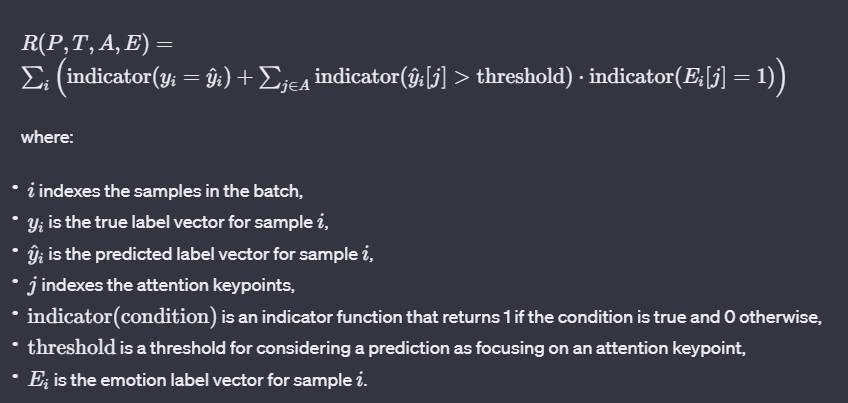

In [50]:
X_train.shape,y_train.shape[0]

((414, 30, 1662), 414)

In [51]:
model

In [52]:
for i in range(y_train.shape[0]):
    X_batch = np.expand_dims(X_train[i], axis=0)
    print(i,model(X_batch))
# print(y_batch)

0 tf.Tensor([[0.2918774  0.00110781 0.137156   0.16274492 0.00317149 0.40394235]], shape=(1, 6), dtype=float32)
1 tf.Tensor([[0.17091963 0.06672319 0.20381032 0.24276267 0.05829655 0.25748762]], shape=(1, 6), dtype=float32)
2 tf.Tensor([[0.00288642 0.39918095 0.0031099  0.01939351 0.574412   0.00101725]], shape=(1, 6), dtype=float32)
3 tf.Tensor([[0.02523608 0.5619711  0.07787476 0.10827637 0.22237293 0.00426875]], shape=(1, 6), dtype=float32)
4 tf.Tensor([[0.01609522 0.33505356 0.01880777 0.05847699 0.5657534  0.00581308]], shape=(1, 6), dtype=float32)
5 tf.Tensor(
[[6.3672243e-04 6.8675518e-01 1.4616374e-04 2.1312632e-02 2.9088399e-01
  2.6532312e-04]], shape=(1, 6), dtype=float32)
6 tf.Tensor([[0.10735586 0.09295834 0.1233118  0.33898208 0.1061469  0.23124506]], shape=(1, 6), dtype=float32)
7 tf.Tensor(
[[2.2207803e-07 4.7076720e-01 1.0535610e-07 9.1259723e-04 5.2831966e-01
  2.3716295e-07]], shape=(1, 6), dtype=float32)
8 tf.Tensor([[0.05818174 0.04659942 0.58487606 0.25117788 0.00

In [53]:
X_batch = np.expand_dims(X_train[i], axis=0)
print(model(X_batch))

tf.Tensor([[0.08871397 0.02373124 0.14811267 0.41678953 0.02386517 0.2987874 ]], shape=(1, 6), dtype=float32)


In [54]:
model.predict(X_train)

13/13 [==============================] - 1s 48ms/step


array([[0.29187852, 0.00110781, 0.13715473, 0.16274445, 0.00317151,
        0.40394306],
       [0.17091924, 0.0667234 , 0.20380975, 0.24276322, 0.05829683,
        0.2574875 ],
       [0.00288642, 0.39918217, 0.0031099 , 0.01939357, 0.5744106 ,
        0.00101726],
       ...,
       [0.07966363, 0.24594939, 0.10204825, 0.17752294, 0.33132914,
        0.06348669],
       [0.05679145, 0.09627298, 0.4345085 , 0.33771002, 0.02407483,
        0.05064227],
       [0.08871439, 0.02373134, 0.14811315, 0.41678846, 0.02386525,
        0.29878747]], dtype=float32)

In [55]:
# predictions

In [56]:
num_epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
threshold_value = 0.5
total_iterations = 0

In [62]:
import numpy as np
import tensorflow as tf

def calculate_reward(predictions, true_labels):
    rewards = []

    for i in range(len(predictions)):
        pred = predictions[i]
        true_labels_np = true_labels[i]

        correct_prediction_reward = 1.0 if np.argmax(pred) == np.argmax(true_labels_np) else 0.0
        rewards.append(correct_prediction_reward)

    return rewards


In [84]:
for epoch in range(num_epochs):
    for i in range((y_train.shape[0])):
        X_batch, y_batch, emotion_labels_batch=X_train[i],y_train[i],emotion_labels_train[i]
        total_iterations += 1
        with tf.GradientTape() as tape:
            # Add batch dimension to X_batch
            X_batch = np.expand_dims(X_batch, axis=0)
            # print(X_batch)
            
            predictions = model(X_batch)
        
            # print("Predictions:", predictions)
            
            rewards = calculate_reward(predictions, y_batch)
            # print(predictions)
            loss = -tf.reduce_mean(tf.math.log(tf.reduce_sum(predictions * y_batch, axis=1)) * rewards)

            loss_value = loss.numpy()
            
            if np.isinf(loss_value):
                continue
            elif np.isnan(loss_value):
                continue
            
            # print("Loss:", loss_value)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if(total_iterations%100==0):
            print(f"Iteration {total_iterations}, Epoch {epoch + 1}, Loss: {loss.numpy()}")


Iteration 2000, Epoch 1, Loss: 0.0
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\keras\src\backend.py", line 5160, in <genexpr>
    output_ta_t = tuple(  File "H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Iteration 2100, Epoch 1, Loss: 0.0
Iteration 2300, Epoch 1, Loss: 0.0
Iteration 2400, Epoch 2, Loss: 0.0
Iteration 2500, Epoch 2, Loss: 0.0
Iteration 2800, Epoch 2, Loss: 0.0
Iteration 2900, Epoch 3, Loss: 0.0
Iteration 3000, Epoch 3, Loss: 0.0
Iteration 3100, Epoch 3, Loss: 0.0
Iteration 3200, Epoch 3, Loss: 0.0
Iteration 3400, Epoch 4, Loss: 0.0
Iteration 3500, Epoch 4, Loss: 0.0
Iteration 3600, Epoch 4, Loss: 0.0
Iterat

In [85]:
print("Hello")

Hello


In [86]:
X_train[0]

array([[ 0.56435299,  0.35058251, -1.53903103, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56354904,  0.35084385, -1.54106259, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56367815,  0.35082406, -1.50732887, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.55834359,  0.42323029, -1.23260713, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55912405,  0.40156174, -1.19430852, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.55914253,  0.40188727, -1.27352691, ...,  0.        ,
         0.        ,  0.        ]])

In [87]:
# model.save_weights('modified_weights.h5')

In [88]:
res = model.predict(X_test)

2/2 [==============================] - 0s 21ms/step


In [89]:
X_test

array([[[ 6.57501757e-01,  5.23467481e-01, -8.15172315e-01, ...,
          6.63831294e-01,  4.06959087e-01, -4.67546657e-02],
        [ 6.58459306e-01,  4.47768390e-01, -8.36164296e-01, ...,
          6.69095874e-01,  3.45797718e-01, -5.01816459e-02],
        [ 6.58348560e-01,  4.60221529e-01, -8.08133602e-01, ...,
          5.99960029e-01,  5.14933348e-01, -2.74218917e-02],
        ...,
        [ 6.61615908e-01,  4.54970479e-01, -8.40893149e-01, ...,
          6.33005440e-01,  3.56895208e-01, -5.04993424e-02],
        [ 6.63804173e-01,  4.15722489e-01, -8.37673664e-01, ...,
          6.11296296e-01,  3.87075722e-01, -5.25513776e-02],
        [ 6.70506418e-01,  4.17331606e-01, -8.24727535e-01, ...,
          5.98145425e-01,  3.95649076e-01, -5.63395247e-02]],

       [[ 5.87774158e-01,  6.25172436e-01, -1.39595866e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.87755859e-01,  6.26351416e-01, -1.38946629e+00, ...,
          0.00000000e+00,  0.00000000e

In [90]:
res

array([[1.76945723e-15, 9.99997973e-01, 4.77812609e-19, 2.04475396e-06,
        3.35825345e-09, 4.53584851e-19],
       [4.67119506e-16, 8.95358086e-01, 2.25305048e-05, 1.19006690e-17,
        2.08984761e-06, 1.04617335e-01],
       [2.49511504e-27, 1.00000000e+00, 7.33862957e-31, 4.52057513e-17,
        3.67549827e-12, 1.38015366e-34],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 3.70997350e-28,
        2.36862905e-32, 0.00000000e+00],
       [5.01028586e-15, 5.53789223e-03, 7.27631768e-13, 6.81545542e-10,
        9.94462073e-01, 1.54722303e-18],
       [2.62779223e-31, 1.00000000e+00, 0.00000000e+00, 3.48593683e-16,
        2.51023957e-14, 2.76418745e-37],
       [7.13270447e-06, 1.91430550e-03, 3.60807851e-02, 5.54658364e-09,
        3.04866880e-02, 9.31511104e-01],
       [1.23788317e-28, 1.00000000e+00, 2.82224184e-25, 5.51827777e-21,
        9.35594284e-22, 5.58638476e-24],
       [6.34236746e-22, 1.00000000e+00, 5.64904640e-31, 1.02107021e-11,
        1.45380676e-19, 

In [91]:
actions[np.argmax(res[4])]

'sad'

In [92]:
actions[np.argmax(y_test[4])]

'happy'

In [93]:
# model.save('action_with_reward_1.h5')

In [94]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [95]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 14ms/step


In [96]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [97]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[28,  0],
        [ 8,  0]],

       [[ 3, 29],
        [ 1,  3]],

       [[28,  0],
        [ 8,  0]],

       [[29,  0],
        [ 7,  0]],

       [[30,  2],
        [ 4,  0]],

       [[29,  2],
        [ 5,  0]]], dtype=int64)

In [98]:
accuracy_score(ytrue, yhat)

0.08333333333333333

In [ ]:
for num, prob in enumerate(res):
    print(num,prob)

In [ ]:
from scipy import stats

In [ ]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


In [ ]:
# prob_viz(res[0], actions, image, colors)

In [ ]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model("action_with_reward_1.h5")

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(image)

In [ ]:
# history

In [ ]:
res

In [ ]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

In [ ]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 3 elements:", top_indices)

In [ ]:
ans=[]

In [ ]:
for i in top_indices:
    ans.append(actions[i])

In [ ]:
ans

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
res

In [ ]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(image)

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("fear20.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
res

In [ ]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

In [ ]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 650))
plt.imshow(resized_image)
plt.show()